# 12wk-2: NYCTaxi 자료 분석 (2)

최규빈  
2023-11-22

<a href="https://colab.research.google.com/github/guebin/DV2023/blob/main/posts/12wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xXZmSbTDYrghHNRkOBj-Es&si=iQeuCDt8Z_D3uzoq>

# 2. Imports

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

In [2]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

# 3. 데이터준비

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv")
df_feature = df.assign(
    log_trip_duration = np.log(df.trip_duration),
    pickup_datetime = df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = df.dropoff_datetime.apply(pd.to_datetime),
    dist = np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)

In [4]:
df_feature.head()

# 4. 시각화3 – 애니메이션

## A. scatter / (vendor_id,passenger_count,hour)

`-` 시각화

In [5]:
df_feature.columns

In [6]:
fig = px.scatter_mapbox(
    data_frame=df_feature.sort_values('pickup_hour'),
    lat = 'pickup_latitude',
    lon = 'pickup_longitude',
    color = 'vendor_id',
    size = 'passenger_count', size_max = 5,
    animation_frame = 'pickup_hour',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600
)
fig.show(config={'scrollZoom':False})

-   B가 전체적으로 동그라미가 크다. (한 택시에 탑승하는 승객수는 B업체가
    더 많은듯)
-   시간대별로 확실히 빈도수가 다르다.

`-` 추가시각화1 – `vendor_id`별 `passenger_count`를 barplot으로 시각화

In [7]:
df_feature.groupby('vendor_id').agg({'passenger_count':'mean'})\
.reset_index()\
.plot.bar(y='vendor_id',x='passenger_count',color='vendor_id')

-   B가 한 택시당 평균승객이 많다. (B는 대형차량위주로 운행하는 회사이지
    않을까?)

`-` 추가시각화2 – `vendor_id`별 `passenger_count`를 boxplot으로 시각화

In [8]:
df_feature.plot.box(x='vendor_id',y='passenger_count',color='vendor_id')

`-` 추가시각화3 – `vendor_id`별 `passenger_count`를 histogram으로 시각화

In [9]:
df_feature.plot.hist(x='passenger_count',color='vendor_id', facet_col='vendor_id')

`-` 추가시각화4 – `pickup_hour`별 `count`를 barplot으로 시각화

In [10]:
df_feature.pickup_hour.value_counts().sort_index().plot.bar()

`-` 추가시각화5 – (`pickup_hour`,`vendor_id`)별 `count`를 barplot으로
시각화

In [11]:
df_feature.groupby(['pickup_hour','vendor_id'])\
.agg('size').reset_index().rename({0:'count'},axis=1)\
.plot.bar(x='pickup_hour',y='count',color='vendor_id',facet_col='vendor_id')

`-` 추가시각화6 – (`pickup_hour`,`vendor_id`)별 `count`를 areaplot으로
시각화

In [12]:
df_feature.groupby(['pickup_hour','vendor_id'])\
.agg('size').reset_index().rename({0:'count'},axis=1)\
.plot.area(x='pickup_hour',y='count',color='vendor_id')

`-` 추가시각화7 – (`pickup_hour`,`vendor_id`)별 `count`를 lineplot으로
시각화

In [13]:
df_feature.groupby(['pickup_hour','vendor_id'])\
.agg('size').reset_index().rename({0:'count'},axis=1)\
.plot.line(x='pickup_hour',y='count',color='vendor_id')

## B. scatter / (vendor_id,day_of_week)

In [14]:
fig = px.scatter_mapbox(
    data_frame=df_feature.sort_values('dayofweek'),
    lat = 'pickup_latitude',
    lon = 'pickup_longitude',
    color = 'vendor_id',
    size = 'passenger_count', size_max = 5,
    animation_frame = 'dayofweek',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600
)
fig.show(config={'scrollZoom':False})

-   생각보다 요일별 특징은 그다지 뚜렷하지 않음.

# 5. 시각화4 – `heatmap`

## A. (요일,시간)에 따른 `count` 시각화

In [15]:
tidydata = df_feature.pivot_table(
    index = 'pickup_hour',
    columns = 'dayofweek',
    aggfunc = 'size'
).stack().reset_index().rename({0:'count'},axis=1)
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='count',
    nbinsx=24,
    nbinsy=7,
    height=300
)

-   노란색: 불금? 피크타임?

## B. (요일,시간)에 따른 `dist` 시각화

In [16]:
tidydata = df_feature.pivot_table(
    index = 'pickup_hour',
    columns = 'dayofweek',
    values = 'dist',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'dist_mean'},axis=1)
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='dist_mean',
    nbinsx=24,
    nbinsy=7,
    height=300
)

-   노란색: 일요일 아침부터 장거리.. (여행을 끝나고 복귀하는 사람들이지
    않을까?)

## C. (요일,시간)에 따른 `speed` 시각화

In [17]:
tidydata = df_feature.pivot_table(
    index = 'pickup_hour',
    columns = 'dayofweek',
    values = 'speed',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'speed_mean'},axis=1)
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='speed_mean',
    nbinsx=24,
    nbinsy=7,
    height=300
)

-   남색: 교통체증이 심한 곳 / 노란색: 교통체증이 덜한 곳

# 6. 시각화5 – 경로시각화

`-` 이거는 너무 무거워서 좀 작은 데이터로 실습합니다.

In [18]:
df_feature_small = df_feature[::100].reset_index(drop=True)
df_feature_small

## A. 예비학습

`-` 경로그리기

In [19]:
df_sample = pd.DataFrame(
    {'path':['A','A','B','B','B'],
     'lon':[-73.986420,-73.995300,-73.975922,-73.988922,-73.962654],
     'lat':[40.756569,40.740059,40.754192,40.762859,40.772449]}
)

In [20]:
df_sample

In [21]:
fig = px.line_mapbox(
    data_frame=df_sample,
    lat = 'lat',
    lon = 'lon',
    color = 'path',
    line_group = 'path',
    #---#
    mapbox_style = 'carto-positron',
    zoom=12,
    width = 750,
    height = 600    
)
fig.show(config={'scrollZoom':False})

`-` 산점도로 그리기

In [22]:
_fig = px.scatter_mapbox(
    data_frame=df_sample,
    lat = 'lat',
    lon = 'lon',
    color = 'path',
    #---#
    mapbox_style = 'carto-positron',
    zoom=12,
    width = 750,
    height = 600    
)
_fig.show(config={'scrollZoom':False})

`-` 합치기

In [23]:
fig = px.line_mapbox(
    data_frame=df_sample,
    lat = 'lat',
    lon = 'lon',
    color = 'path',
    line_group = 'path',
    #---#
    mapbox_style = 'carto-positron',
    zoom=12,
    width = 750,
    height = 600    
)
scatter_data = px.scatter_mapbox(
    data_frame=df_sample,
    lat = 'lat',
    lon = 'lon',
    color = 'path',
    #---#
    mapbox_style = 'carto-positron',
    zoom=12,
    width = 750,
    height = 600    
).data 
fig.add_trace(scatter_data[0])
fig.add_trace(scatter_data[1])
fig.show(config={'scrollZoom':False})

## B. 전처리

In [24]:
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_feature_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_feature_small.groupby('id')]).reset_index(drop=True)
df_feature_small2 = df_left.merge(df_right)
df_feature_small2.head()

## C. `vendor_id`, `passenger_count` 시각화

In [25]:
fig = px.line_mapbox(
    data_frame=df_feature_small2,
    lat = 'latitude',
    lon = 'longitude',
    color = 'vendor_id',
    line_group = 'id',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
)
scatter_data = px.scatter_mapbox(
    data_frame=df_feature_small2,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'vendor_id',
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
).data 
for sd in scatter_data: 
    fig.add_trace(sd)
fig.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)    
fig.show(config={'scrollZoom':False})

## D. `dayofweek`별 시각화

In [26]:
tidydata = df_feature_small2.assign(dayofweek = lambda df: df.dayofweek.astype(str)).sort_values('dayofweek')
fig = px.line_mapbox(
    data_frame=tidydata,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = 'dayofweek',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
)
scatter_data = px.scatter_mapbox(
    data_frame=tidydata,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'dayofweek',
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
).data 
for sd in scatter_data: 
    fig.add_trace(sd)
fig.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)
fig.show(config={'scrollZoom':False})

## E. `speed`별 시각화

In [27]:
tidydata = df_feature_small2.assign(
    speed_cut = pd.qcut(df_feature_small2.speed,4)
).sort_values('speed_cut')
fig = px.line_mapbox(
    data_frame=tidydata,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = 'speed_cut',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
)
scatter_data = px.scatter_mapbox(
    data_frame=tidydata,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'speed_cut',
    #---#
    mapbox_style = 'carto-positron',
    zoom=10,
    width = 750,
    height = 600    
).data 
for sd in scatter_data: 
    fig.add_trace(sd)
fig.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)
fig.show(config={'scrollZoom':False})

/home/cgb2/anaconda3/envs/ag2/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/cgb2/anaconda3/envs/ag2/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


# 7. HW

In [28]:
df_feature.dist.describe()

거리가 0.012819 보다 작은 거리를 근거리로 생각하자. 근거리 이동건수가
많은 요일,시간대를 알고싶다. 예를들어 월요일, 0시 (pickup_hour기준)의
근거리 이동건수는 아래와 같이 구할 수 있다.

In [29]:
len(df_feature.query('dayofweek ==0 and dist<0.012819 and pickup_hour == 0'))

모든 요일, 모든 시간의 근거리 이동건수를 `density_heatmap`을 이용하여
시각화하라.

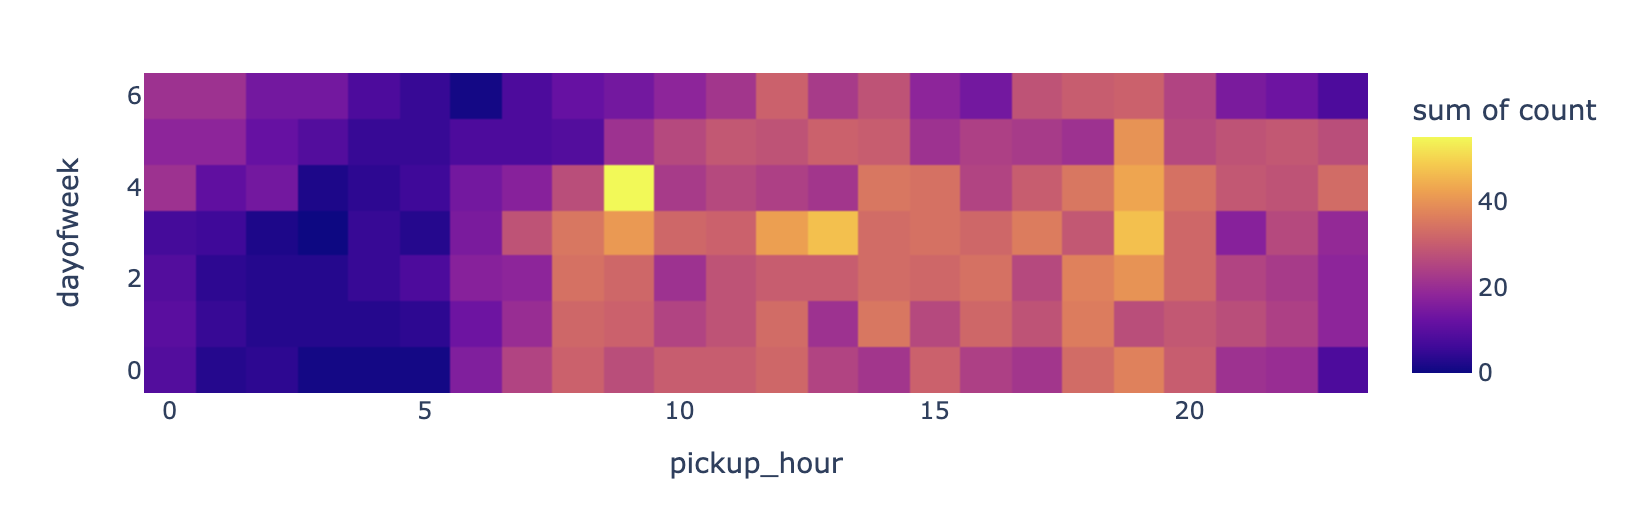